In [1]:
# Make sure the MESmerize dir is in your PYTHONPATH environment variable, else this import won't work
from analyser.DataTypes import Transmission, get_sampling_rate, get_array_size

#### **The saved Transmission file that we will obtain was created through the following flowchart layout**
![title](flowchart_img.png)

In [2]:
# This file was created from the Save node as you can see above
t = Transmission.from_hdf5('./cell_types_rfft_spliced_500_test_units.trn')

#### **Each Transmission object contains a DataFrame and a HistoryTrace instance.**
- The DataFrame consists of one or more datablocks, which is implemented by one DataFrame column that contains a UUID to identify the datablock.
- This allows Transmissions to be merged on the flowchart whilst keeping track of the history for every single row of the DataFrame.
- When Transmissions are merged, the DataFrames from these the individual input Transmissions are concatenated together.

In [3]:
# Since no merging occured in the above flowchart, there is
# only one datablock in this Transmission
t.history_trace.data_blocks

[UUID('ab972d55-7909-4c59-b5b7-ede20a9684bb')]

In [4]:
# Let's just store this datablock ID
db_id = t.history_trace.data_blocks[0]

#### **Our goal is to get the units and (if it makes sense) the frequency linspace of any data column in the DataFrame that the user wants to plot**

In [5]:
# If we list out all the columns in the DataFrame, any column that 
# is in all caps and has a leading underscore was the output of a node
t.df.columns

Index(['CurvePath', 'ImgInfoPath', 'ImgPath', 'MaxProjPath', 'ROI_State',
       'SampleID', 'comments', 'date', 'misc', 'promoter', 'uuid_curve',
       '_RAW_CURVE', 'meta', 'stim_maps', '_BLOCK_', '_SPLICE_ARRAYS',
       '_NORMALIZE', '_RFFT', '_ABSOLUTE_VALUE', '_LOG_TRANSFORM'],
      dtype='object')

In [6]:
# The HistoryTrace instance in the transmission stores the list of
# operations with the same name, but in lowercase without a leading underscore.
# This list is in the order in which the operations were carried out, 
# from first operation (0th index) to last (-1st index)
# You can compare it to the flowchart
t.history_trace.get_operations_list(db_id)

['spawn_transmission',
 'splice_arrays',
 'normalize',
 'rfft',
 'absolute_value',
 'log_transform',
 'splice_arrays']

#### Note how the operations list has both occurances of the splice_arrays operations, corresponding to both usages of the splice_arrays node.
#### However note that there is only one \_SPLICE_ARRAYS data column in the DataFrame. The data columns in the DataFrame always correspond to the data output of the **most recent** usage

#### **Now let's say that the user wants to plot the \_SPLICE_ARRAYS data column output from the last SpliceArrays node. i.e. If the user had placed a plotting node where the Save node currently is (refer to the flowchart image)**

In [7]:
# Data column that the user has requested to plot
data_column = '_SPLICE_ARRAYS'

# Get operation name
op = data_column.lower()[1:]

# Get the params of the data in this column
params = t.history_trace.get_operation_params(db_id, op) # This always returns a dict of the params stored after that node's operations
print(params)

{'data_column': '_LOG_TRANSFORM', 'start_ix': 0, 'end_ix': 500, 'units': 'frequency'}


- **The *'data_column'* key is the data column that was used for *input data* to this node. This param is present in all nodes**
- ***'start_ix'* and *'end_ix'* are the splicing indices that were set by the user**
- **_'units'_ is the data units of the data _output_ from this node. This param is present in all nodes where it makes sense**

In [8]:
# Therefore we can obtain the data units like this
units = t.history_trace.get_operation_params(db_id, op)['units']
print(units)

frequency


### **Note that the get_operation_params method will return the params associated with the most recent occurance of that operation**
#### This is what we always want anyways.
#### If the user wants to plot the data after the first SpliceArrays node, they should put the plot node after that.

#### Just to illustrate, let's see what are the units corresponding to the \_NORMALIZE data column

In [9]:
print(t.history_trace.get_operation_params(db_id, '_NORMALIZE'.lower()[1:])['units'])

time


As you can see, this makes sense since prior to the *Normalize* node, the raw data were loaded by the *Load_Proj_DF* node and then just spliced. The units only changed after the RFFT node as illustrated below

In [10]:
print(t.history_trace.get_operation_params(db_id, '_RFFT'.lower()[1:])['units'])
print(t.history_trace.get_operation_params(db_id, '_ABSOLUTE_VALUE'.lower()[1:])['units'])
print(t.history_trace.get_operation_params(db_id, '_LOG_TRANSFORM'.lower()[1:])['units'])

frequency
frequency
frequency


#### Let's get back to getting information to plot the output of that last SpliceArrays node.

In [11]:
# For the x-axis we need the appropriate linspace, whether it's frequency or time
# If the units are frequency we can just obtain the correct linspace from the rfft params dict!
if units == 'frequency':
    rfft_params = t.history_trace.get_operation_params(db_id, 'rfft')
    # This linspace has the frequency that corresponds to each index of the output data
    linspace = rfft_params['frequencies']
elif units == 'time':
    # Do the stuff to get simple time linspace based on framerate of the data
    # The get_sampling_rate is a helper function that checks to make sure that 
    # the sampling rate of all data in the passed Transmission are within a 
    # certain tolerance, default tolerance is 0.1 Hz
    rate = get_sampling_rate(t)
    # Get the num frames in the timeseries, this methods makes sure they match etc.
    num_frames = get_array_size(t, data_column)

In [12]:
# To illustrate the frequency linspace
print(linspace)

# This will be the Nyquist frequency
print(linspace.max())

[0.00000000e+00 3.34448161e-03 3.34448161e-03 ... 4.99665552e+00
 4.99665552e+00 5.00000000e+00]
5.0


### **Notice that in the flowchart, you can see that the fourier data were spliced before the save noded, set as [0:500].**
### **We can check for this and splice out the corresponding range of the frequency linspace too**

In [13]:
# Let's get the operations list, with which we can see if
# the data were spliced after RFFT
ops_list = t.history_trace.get_operations_list(db_id)

# The above method gives the list of operations in the order they were performed
# So reverse the order to check if the most recent splice arrays was done after rfft
# Therefore after reversal of the list it's index will be before rfft
ops_list.reverse()

# This will return true of the RFFT data were spliced
ops_list.index('splice_arrays') < ops_list.index('rfft')

True

In [14]:
# Get the splicing indices
if ops_list.index('splice_arrays') < ops_list.index('rfft'):
    splice_params = t.history_trace.get_operation_params(db_id, 'splice_arrays')
    start_ix = splice_params['start_ix']
    end_ix = splice_params['end_ix']
    # So then for plotting we can use these indices to get the correct frequency range that correspond to the data.
    # Simply use these indices to grab the range from the freq_linspace from the rfft_params
    linspace = linspace[start_ix:end_ix]

### **Now with all these pieces of information we can make a plot with the right units**

/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,114,'Frequency [Hz]')

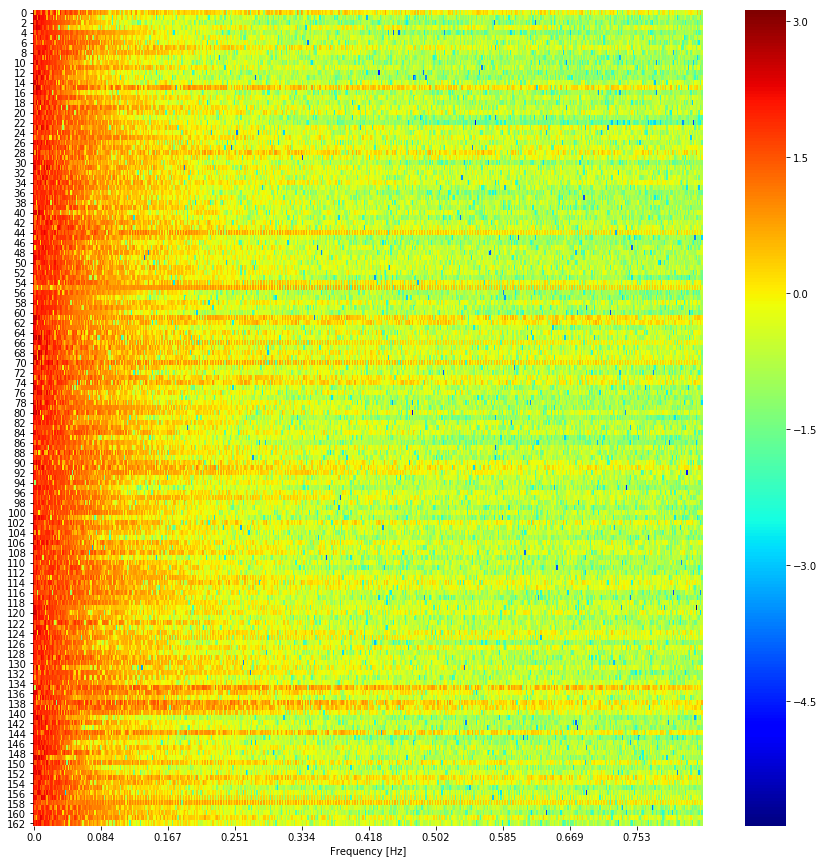

In [15]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
tick_interval = 50

num_ticks = linspace.size / tick_interval
if units == 'frequency':
    # linspace[-1] should correspond to the right edge of the heatmap
    x_ticks = np.linspace(linspace.min(), linspace.max(), num_ticks + 1)
    x_ticks = np.around(x_ticks, decimals = 3)
    x_axis_label = "Frequency [Hz]"
elif units == 'time':
    pass

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
sns.heatmap(np.vstack(t.df['_SPLICE_ARRAYS'].values), cmap='jet', xticklabels=tick_interval, ax=ax)
ax.set_xticklabels(x_ticks)
ax.set_xlabel(x_axis_label)